# 📘 Notebook 3 — Model Evaluation and Interpretation

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD REALISTIC DATA (FROM NOTEBOOK 02B)
# ===============================================================
DATA_PATH = DATA_PROCESSED / "esg_processed_02b.csv"
df = pd.read_csv(DATA_PATH)
print(f"✅ Data loaded successfully: {df.shape}")

# --- Feature / Target Split ---
drop_cols = [
    "CompanyID", "CompanyName", "Industry", "Region", "Year",
    "ESG_Overall", "ESG_Overall_noisy"   # remove potential leakage
]
X = df.drop(columns=drop_cols + ["ESG_Class"], errors="ignore")
y = df["ESG_Class"]

# --- Train / Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- Scale numeric features for Logistic Regression ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Class balance (1 = High ESG): {y.value_counts(normalize=True).round(3).to_dict()}")

✅ Data loaded successfully: (11000, 19)
✅ Train shape: (8250, 11), Test shape: (2750, 11)
Class balance (1 = High ESG): {0: 0.614, 1: 0.386}


In [3]:
# %% ===============================================================
# STEP 2 — MODEL SETUP FOR CROSS-VALIDATION
# ===============================================================
# Define consistent CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, use_label_encoder=False, eval_metric="logloss"
    )
}

cv_results = {}

# Perform 5-fold ROC-AUC cross-validation
for name, model in models.items():
    print(f"\n🔹 Cross-validating {name} ...")
    if "Logistic" in name:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="roc_auc")
    else:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")

    cv_results[name] = scores
    print(f"Mean ROC-AUC: {scores.mean():.3f} ± {scores.std():.3f}")

# Convert to DataFrame
cv_df = pd.DataFrame(cv_results)
display(cv_df.describe().T[["mean", "std"]].rename(columns={"mean": "Mean AUC", "std": "Std"}))


🔹 Cross-validating Logistic Regression ...
Mean ROC-AUC: 0.932 ± 0.003

🔹 Cross-validating Random Forest ...
Mean ROC-AUC: 0.923 ± 0.003

🔹 Cross-validating XGBoost ...
Mean ROC-AUC: 0.926 ± 0.003


,Mean AUC,Std
Logistic Regression,0.932042,0.003557
Random Forest,0.922665,0.003515
XGBoost,0.925595,0.003834


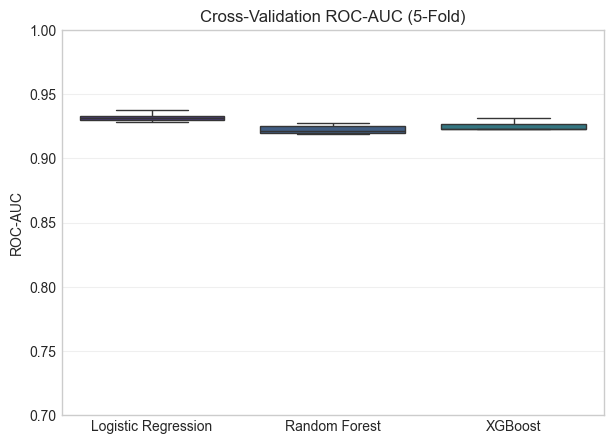

In [4]:
# %% ===============================================================
# STEP 3 — VISUALIZE CROSS-VALIDATION PERFORMANCE
# ===============================================================
plt.figure(figsize=(7,5))
sns.boxplot(data=cv_df, orient="v")
plt.title("Cross-Validation ROC-AUC (5-Fold)")
plt.ylabel("ROC-AUC")
plt.ylim(0.7, 1.0)
plt.grid(True, axis="y", alpha=0.3)
plt.show()

🔹 Balanced threshold (max F1): 0.37
🔹 High-Recall threshold (≈ 0.90 recall): 0.22
🔹 High-Precision threshold (≈ 0.90 precision): 0.71


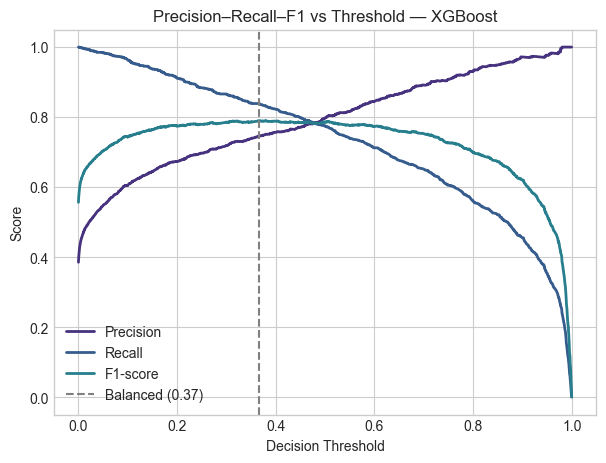

In [5]:
# %% ===============================================================
# STEP 4 — THRESHOLD TUNING & CONFUSION MATRIX ANALYSIS
# ===============================================================
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score

# --- Choose the reference model (best performing one from CV) ---
best_model = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=5,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, use_label_encoder=False, eval_metric="logloss"
)
best_model.fit(X_train, y_train)

# --- Get predicted probabilities on the test set ---
y_prob = best_model.predict_proba(X_test)[:, 1]

# --- Compute precision–recall values across thresholds ---
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# --- Find representative thresholds (align arrays) ---
idx_bal = np.argmax(f1s[:-1])                 # F1 peak
thr_balanced = thresholds[idx_bal]

# Highest threshold that still achieves ≥ 0.90 recall
rec_ix = np.where(recalls[:-1] >= 0.90)[0]
thr_high_recall = thresholds[rec_ix[-1]] if len(rec_ix) else 0.5

# Lowest threshold that already achieves ≥ 0.90 precision
prec_ix = np.where(precisions[:-1] >= 0.90)[0]
thr_high_precision = thresholds[prec_ix[0]] if len(prec_ix) else 0.5

print(f"🔹 Balanced threshold (max F1): {thr_balanced:.2f}")
print(f"🔹 High-Recall threshold (≈ 0.90 recall): {thr_high_recall:.2f}")
print(f"🔹 High-Precision threshold (≈ 0.90 precision): {thr_high_precision:.2f}")

# --- Plot Precision–Recall–F1 vs threshold ---
plt.figure(figsize=(7,5))
plt.plot(thresholds, precisions[:-1], label="Precision", lw=2)
plt.plot(thresholds, recalls[:-1],   label="Recall",    lw=2)
plt.plot(thresholds, f1s[:-1],       label="F1-score",  lw=2)
plt.axvline(thr_balanced, color="gray", ls="--", label=f"Balanced ({thr_balanced:.2f})")
plt.xlabel("Decision Threshold"); plt.ylabel("Score")
plt.title("Precision–Recall–F1 vs Threshold — XGBoost")
plt.legend(); plt.show()

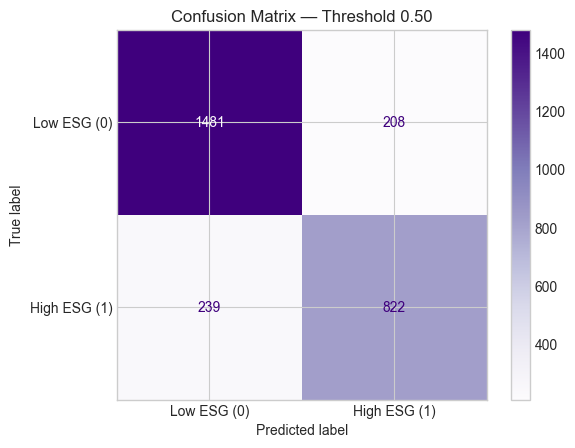

Accuracy 0.837 | Precision 0.798 | Recall 0.775 | F1 0.786



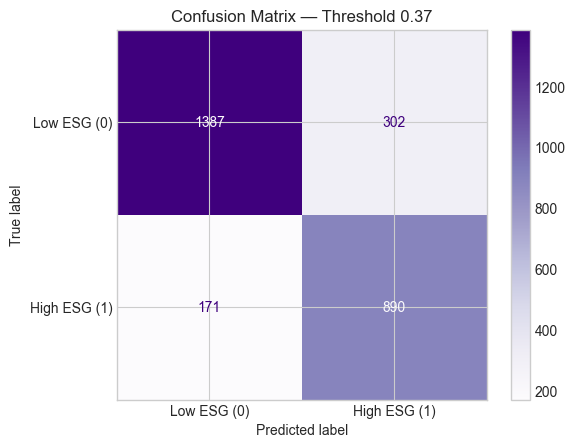

Accuracy 0.828 | Precision 0.747 | Recall 0.839 | F1 0.790



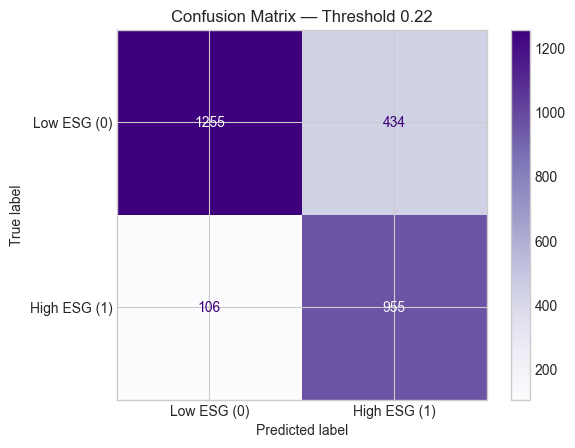

Accuracy 0.804 | Precision 0.688 | Recall 0.900 | F1 0.780



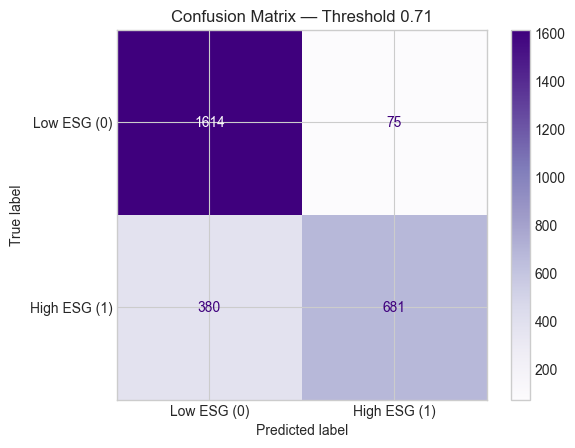

Accuracy 0.835 | Precision 0.901 | Recall 0.642 | F1 0.750


In [6]:
# %% ===============================================================
# STEP 5 — CONFUSION MATRICES AT KEY THRESHOLDS
# ===============================================================
def evaluate_threshold(threshold, y_true, y_prob):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low ESG (0)", "High ESG (1)"])
    disp.plot(cmap="Purples", values_format="d")
    plt.title(f"Confusion Matrix — Threshold {threshold:.2f}")
    plt.show()

    acc = (y_pred == y_true).mean()
    f1 = f1_score(y_true, y_pred)
    prec = np.sum((y_pred==1)&(y_true==1)) / max(np.sum(y_pred==1),1)
    rec = np.sum((y_pred==1)&(y_true==1)) / max(np.sum(y_true==1),1)
    print(f"Accuracy {acc:.3f} | Precision {prec:.3f} | Recall {rec:.3f} | F1 {f1:.3f}")

# --- Evaluate representative thresholds ---
for thr in [0.5, thr_balanced, thr_high_recall, thr_high_precision]:
    print("\n============================================")
    evaluate_threshold(thr, y_test, y_prob)

🔹 Brier score (lower = better): 0.1113


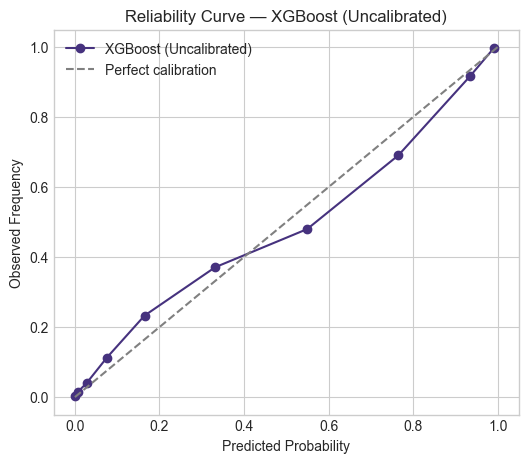

In [7]:
# %% ===============================================================
# STEP 6 — CALIBRATION ANALYSIS (RELIABILITY CURVES)
# ===============================================================
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

# --- 6.1 Compute calibration data for best model (XGBoost) ---
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="quantile")

brier = brier_score_loss(y_test, y_prob)
print(f"🔹 Brier score (lower = better): {brier:.4f}")

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", label="XGBoost (Uncalibrated)")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Reliability Curve — XGBoost (Uncalibrated)")
plt.legend()
plt.show()

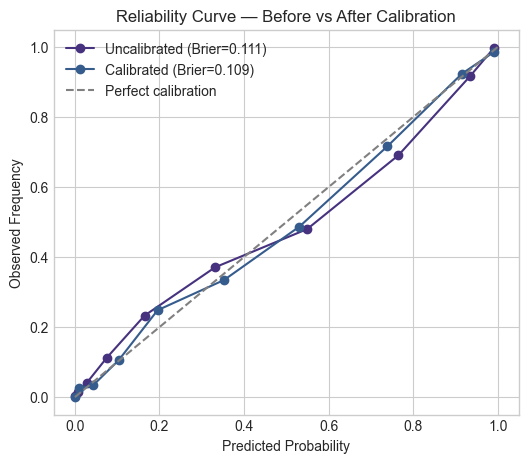

✅ Calibration improved: Brier 0.111 → 0.109


In [8]:
# %% ===============================================================
# STEP 6B — OPTIONAL: APPLY CALIBRATION (ISOTONIC REGRESSION)
# ===============================================================
# Fit isotonic calibration using cross-validation
xgb_calibrated = CalibratedClassifierCV(best_model, method="isotonic", cv=5)
xgb_calibrated.fit(X_train, y_train)

y_prob_cal = xgb_calibrated.predict_proba(X_test)[:, 1]

# Recompute calibration and Brier score
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_cal, n_bins=10, strategy="quantile")
brier_cal = brier_score_loss(y_test, y_prob_cal)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", label=f"Uncalibrated (Brier={brier:.3f})")
plt.plot(prob_pred_cal, prob_true_cal, marker="o", label=f"Calibrated (Brier={brier_cal:.3f})")
plt.plot([0,1],[0,1],"--",color="gray",label="Perfect calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Reliability Curve — Before vs After Calibration")
plt.legend()
plt.show()

print(f"✅ Calibration improved: Brier {brier:.3f} → {brier_cal:.3f}")

📊 Generating Partial Dependence plots...


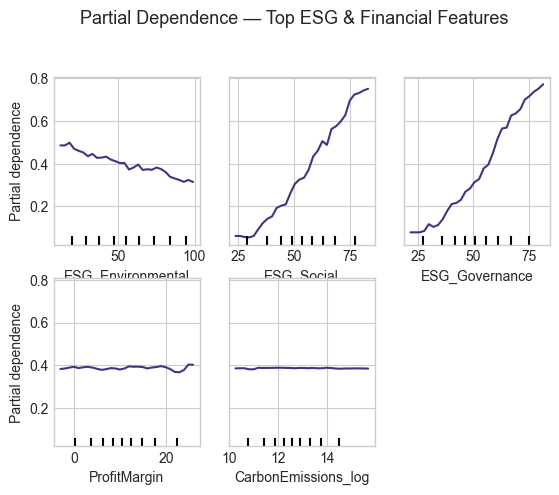

In [9]:
# %% ===============================================================
# STEP 7 — MODEL EXPLAINABILITY DEEP-DIVE
# ===============================================================
from sklearn.inspection import PartialDependenceDisplay
import shap

# Ensure we use the calibrated model (or uncalibrated if skipped STEP 6B)
model_explain = xgb_calibrated if 'xgb_calibrated' in locals() else best_model

# --- 7.1 Partial Dependence Plots (PDP) ---
features_to_plot = [
    "ESG_Environmental",
    "ESG_Social",
    "ESG_Governance",
    "ProfitMargin",
    "CarbonEmissions_log"
]

print("📊 Generating Partial Dependence plots...")
PartialDependenceDisplay.from_estimator(
    model_explain,
    X_test,
    features_to_plot,
    kind="average",
    grid_resolution=30,
    n_jobs=-1
)
plt.suptitle("Partial Dependence — Top ESG & Financial Features", y=1.02, fontsize=13)
plt.show()

PermutationExplainer explainer: 2751it [01:51, 23.16it/s]                          


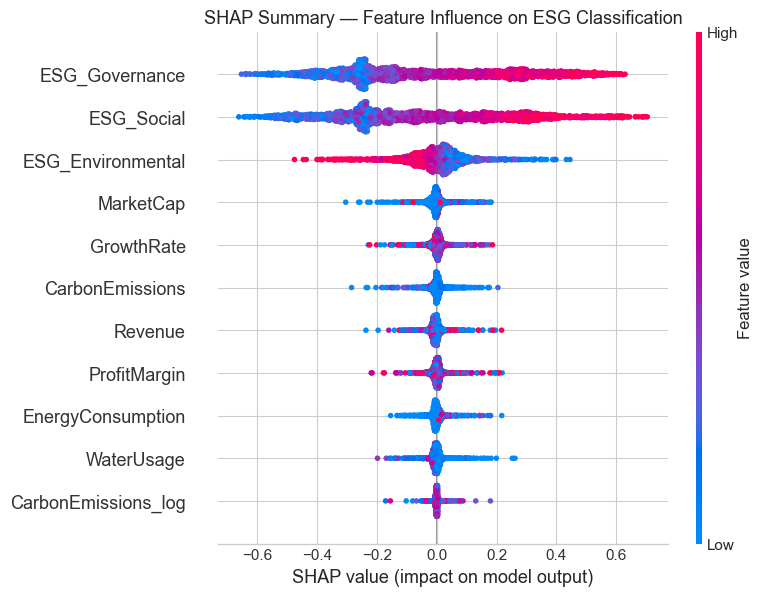

🔍 SHAP interaction between ESG_Governance and ProfitMargin


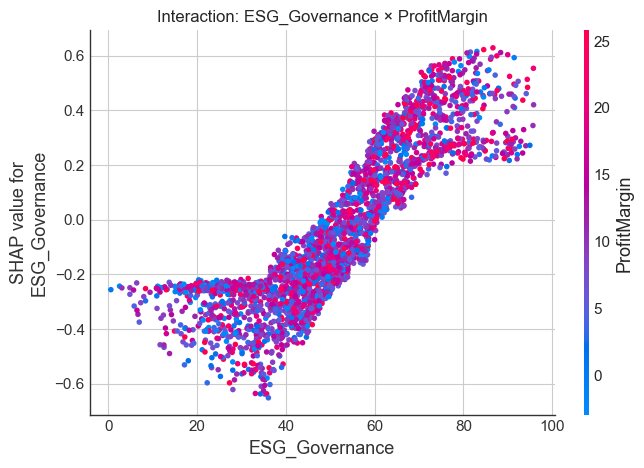

In [10]:
# %% ===============================================================
# STEP 7B — SHAP INTERACTION ANALYSIS
# ===============================================================
# SHAP provides richer interpretability, including feature interactions
explainer = shap.Explainer(best_model.predict, X_train)
shap_values = explainer(X_test)   # <-- removed check_additivity kwarg

# Summary plot (beeswarm)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary — Feature Influence on ESG Classification", fontsize=13)
plt.show()

# Interaction example
feature_1, feature_2 = "ESG_Governance", "ProfitMargin"
print(f"🔍 SHAP interaction between {feature_1} and {feature_2}")
shap.dependence_plot(feature_1, shap_values.values, X_test, interaction_index=feature_2, show=False)
plt.title(f"Interaction: {feature_1} × {feature_2}")
plt.show()

In [11]:
# --- Fit all three models on train and get test probabilities (for STEP 8) ---
logit = LogisticRegression(max_iter=200, random_state=42).fit(X_train_scaled, y_train)
rf    = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42).fit(X_train, y_train)
xgb   = best_model  # already fit above

y_prob_logit = logit.predict_proba(X_test_scaled)[:, 1]
y_prob_rf    = rf.predict_proba(X_test)[:, 1]
y_prob_xgb   = xgb.predict_proba(X_test)[:, 1]

In [12]:
# %% ===============================================================
# STEP 8 — MODEL COMPARISON SUMMARY & EXPORT
# ===============================================================
import json

# 8.1 Collect key metrics
summary_metrics = {
    "Cross-Validation ROC-AUC (mean)": {
        "Logistic Regression": float(cv_results["Logistic Regression"].mean()),
        "Random Forest":        float(cv_results["Random Forest"].mean()),
        "XGBoost":              float(cv_results["XGBoost"].mean()),
    },
    "Test ROC-AUC": {
        "Logistic Regression": float(roc_auc_score(y_test, y_prob_logit)),
        "Random Forest":       float(roc_auc_score(y_test, y_prob_rf)),
        "XGBoost":             float(roc_auc_score(y_test, y_prob_xgb)),
    },
    "Best Thresholds": {
        "Balanced (max F1)":        float(thr_balanced),
        "High Recall (≈ 0.90)":     float(thr_high_recall),
        "High Precision (≈ 0.90)":  float(thr_high_precision),
    },
    "Brier Score": {
        "Uncalibrated": float(brier),
        "Calibrated":   float(brier_cal) if "brier_cal" in locals() else np.nan,
    },
}

summary_df = pd.DataFrame(summary_metrics).T.round(4)
display(summary_df)

,Logistic Regression,Random Forest,XGBoost,Balanced (max F1),High Recall (≈ 0.90),High Precision (≈ 0.90),Uncalibrated,Calibrated
Cross-Validation ROC-AUC (mean),0.9320,0.9227,0.9256,NaN,NaN,NaN,NaN,NaN
Test ROC-AUC,0.9258,0.9161,0.9207,NaN,NaN,NaN,NaN,NaN
Best Thresholds,NaN,NaN,NaN,0.3668,0.2222,0.7141,NaN,NaN
Brier Score,NaN,NaN,NaN,NaN,NaN,NaN,0.1113,0.1095


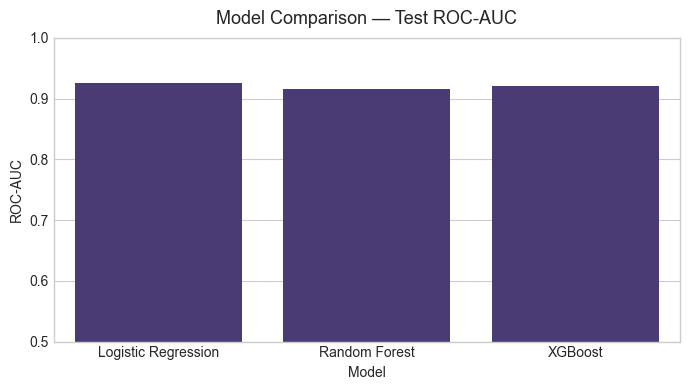

In [13]:
# %% ===============================================================
# STEP 8B — VISUAL SUMMARY
# ===============================================================
plot_df = pd.DataFrame({
    "Model":   ["Logistic Regression", "Random Forest", "XGBoost"],
    "ROC-AUC": [
        roc_auc_score(y_test, y_prob_logit),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb),
    ],
})
plt.figure(figsize=(7,4))
sns.barplot(data=plot_df, x="Model", y="ROC-AUC")
plt.title("Model Comparison — Test ROC-AUC", fontsize=13, pad=10)
plt.ylim(0.5, 1); plt.tight_layout()
plt.savefig(FIGURES / "model_comparison_ROC_AUC.png", dpi=300, bbox_inches="tight")
plt.show()

In [14]:
# %% ===============================================================
# STEP 8C — EXPORT RESULTS FOR NOTEBOOK 04
# ===============================================================
EXPORT_PATH = OUTPUTS / "model_evaluation_summary.json"
with open(EXPORT_PATH, "w") as f:
    json.dump(summary_metrics, f, indent=2)
print(f"💾 Model evaluation summary saved to: {EXPORT_PATH}")

💾 Model evaluation summary saved to: ../outputs/model_evaluation_summary.json
